In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

In [27]:
def get_good_img(img,close_y,close_x,open_y,open_x):#顶帽运算，降低亮度影响，只留单词区域为灰色
    
    name = time.time()
    # cv2.imwrite("duijie_img_debug/"+str(name)+'1.jpg', img)
    img=cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C ,cv2.THRESH_BINARY_INV,51,20)
    #闭运算
    kernel = np.ones((2,2),np.uint8)#5,5
    img = cv2.dilate(img,kernel,iterations = 1)
    #cv2.imwrite("duijie_img_debug/"+str(name)+'c.jpg', img)
    kernel = np.ones((close_y,close_x),np.uint8)#5,5
    close= cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    # cv2.imwrite("duijie_img_debug/"+str(name)+'d.jpg', close)
    #开运算
    kernel = np.ones((open_y,open_x),np.uint8)#3,3
    open_img = cv2.morphologyEx(close, cv2.MORPH_OPEN, kernel)
    plt.imshow(open_img)
    plt.show()
    return open_img


In [41]:
# 得到峰左右index
# 先用阈值得到峰的index群体
# 接着得到峰中间的谷低的index群体
# 向下扫描，试图得到新峰新谷，直到老峰老谷开始消失:
# 从1/3max峰值开始往下扫描，出现新的峰就意味着出现新的谷，最近的新峰的值和新谷的值相减：
# 1.如果大于一定的数值，说明是高峰和低谷的关系，纳入之前找的峰谷里面。
# 2.如果小于一定的数值，说明是那种垃圾峰和谷，就接着往下扫描。

def get_index(arr,th):
    top = np.where(arr>th)[0]
    index_dic = top[1:]-top[:-1]
    top_dic_index = np.where(index_dic>1)[0]
    part_right_index = top[top_dic_index]
    right_index = np.zeros(len(part_right_index)+1)
    right_index[-1] = len(arr)
    right_index[:-1] = part_right_index
    right_index = np.int64(right_index+1)

    part_left_index = top[top_dic_index]+index_dic[top_dic_index]
    left_index = np.zeros(len(part_left_index)+1)
    left_index[1:] = part_left_index
    left_index = np.int64(left_index)
    
    #得到峰中间的谷低的index群体
    bottom_area = np.zeros(len(part_left_index))
    for num in range(len(part_left_index)):
        area = arr[part_right_index[num]:part_left_index[num]]
        if len(area)>0:
            min_index = np.where(area==np.min(area))[0]+part_right_index[num]
            bottom_area[num] = min_index[int(len(min_index)/2)]
     #得到峰的index群体
    top_area = np.zeros(len(left_index))
    for num in range(len(left_index)):
        area = arr[left_index[num]:right_index[num]]
        if len(area)>0:
            max_index = np.where(area==np.max(area))[0]+left_index[num]
            top_area[num] = max_index[int(len(max_index)/2)]
    return top_area,bottom_area

In [42]:
def get_row(img):
    img_mean_y = img.mean(axis=1)
    top_area,bottom_area = get_index(arr = img_mean_y,th =30)
    fir_row = np.where(img_mean_y>0)[0]
    if len(fir_row) >0:
        fir_row = np.where(img_mean_y>0)[0][0]
    else:
        fir_row=0
    end_row = np.where(img_mean_y>0)[0]
    if len(end_row) >0:
        end_row = np.where(img_mean_y>0)[0][-1]
    else:
        end_row=len(img_mean_y)-1
    if fir_row >10:
        fir_row-=10
    else:
        fir_row=0
    if len(img_mean_y)-1-end_row>10:
        end_row+=10
    else:
        end_row=len(img_mean_y)-1
    return bottom_area,fir_row,end_row

In [43]:
def get_column(img,first_row,second_row):
    img = get_good_img(img[int(first_row):int(second_row),:],30,2,5,5)
    y = img.min(axis=0)
    top_area_x,bottom_area_x = get_index(y,th = 30)
    fir_column = np.where(y>0)[0]
    if len(fir_column)>0:
        fir_column = np.where(y>0)[0][0]
    else:
        fir_column=0
    end_column = np.where(y>0)[0]
    if len(end_column)>0:
        end_column = np.where(y>0)[0][-1]
    else:
        end_column = len(y)-1
    if fir_column > 10:
        fir_column-=10
    else:
        fir_column=0
    if len(y)-1-end_column>10:
        end_column+=10
    else:
        end_column=len(y)-1
    return bottom_area_x,fir_column,end_column

In [48]:
def get_all_column(good_img,row):
    all_column_area = []
    for idx in range(len(row)-1):
        column_area,fir_column,end_column = get_column(good_img,row[idx],row[idx+1])
        new_column_area = np.zeros(len(column_area)+2)
        new_column_area[0]=fir_column
        new_column_area[1:-1]=column_area
        new_column_area[-1]=end_column
        all_column_area.append(new_column_area)
    return all_column_area


In [49]:
def run(img):
    good_img = get_good_img(img,2,30,1,1)
    row_area,fir_row,end_row = get_row(good_img)
    print(row_area)
    new_row_area = np.zeros(len(row_area)+2)
    new_row_area[0]=fir_row
    new_row_area[1:-1]=row_area+3
    new_row_area[-1]=end_row
    all_column_area = get_all_column(img,new_row_area)
    words_index = []
    for num in range(1,len(all_column_area)+1):
        word_column = np.zeros((len(all_column_area[num-1])-1,4))
        word_column[:,1] = new_row_area[num-1]
        word_column[:,3] = new_row_area[num]
        word_column[:,0] = all_column_area[num-1][:-1]
        word_column[:,2] = all_column_area[num-1][1:]
        words_index.append(word_column)


    return words_index


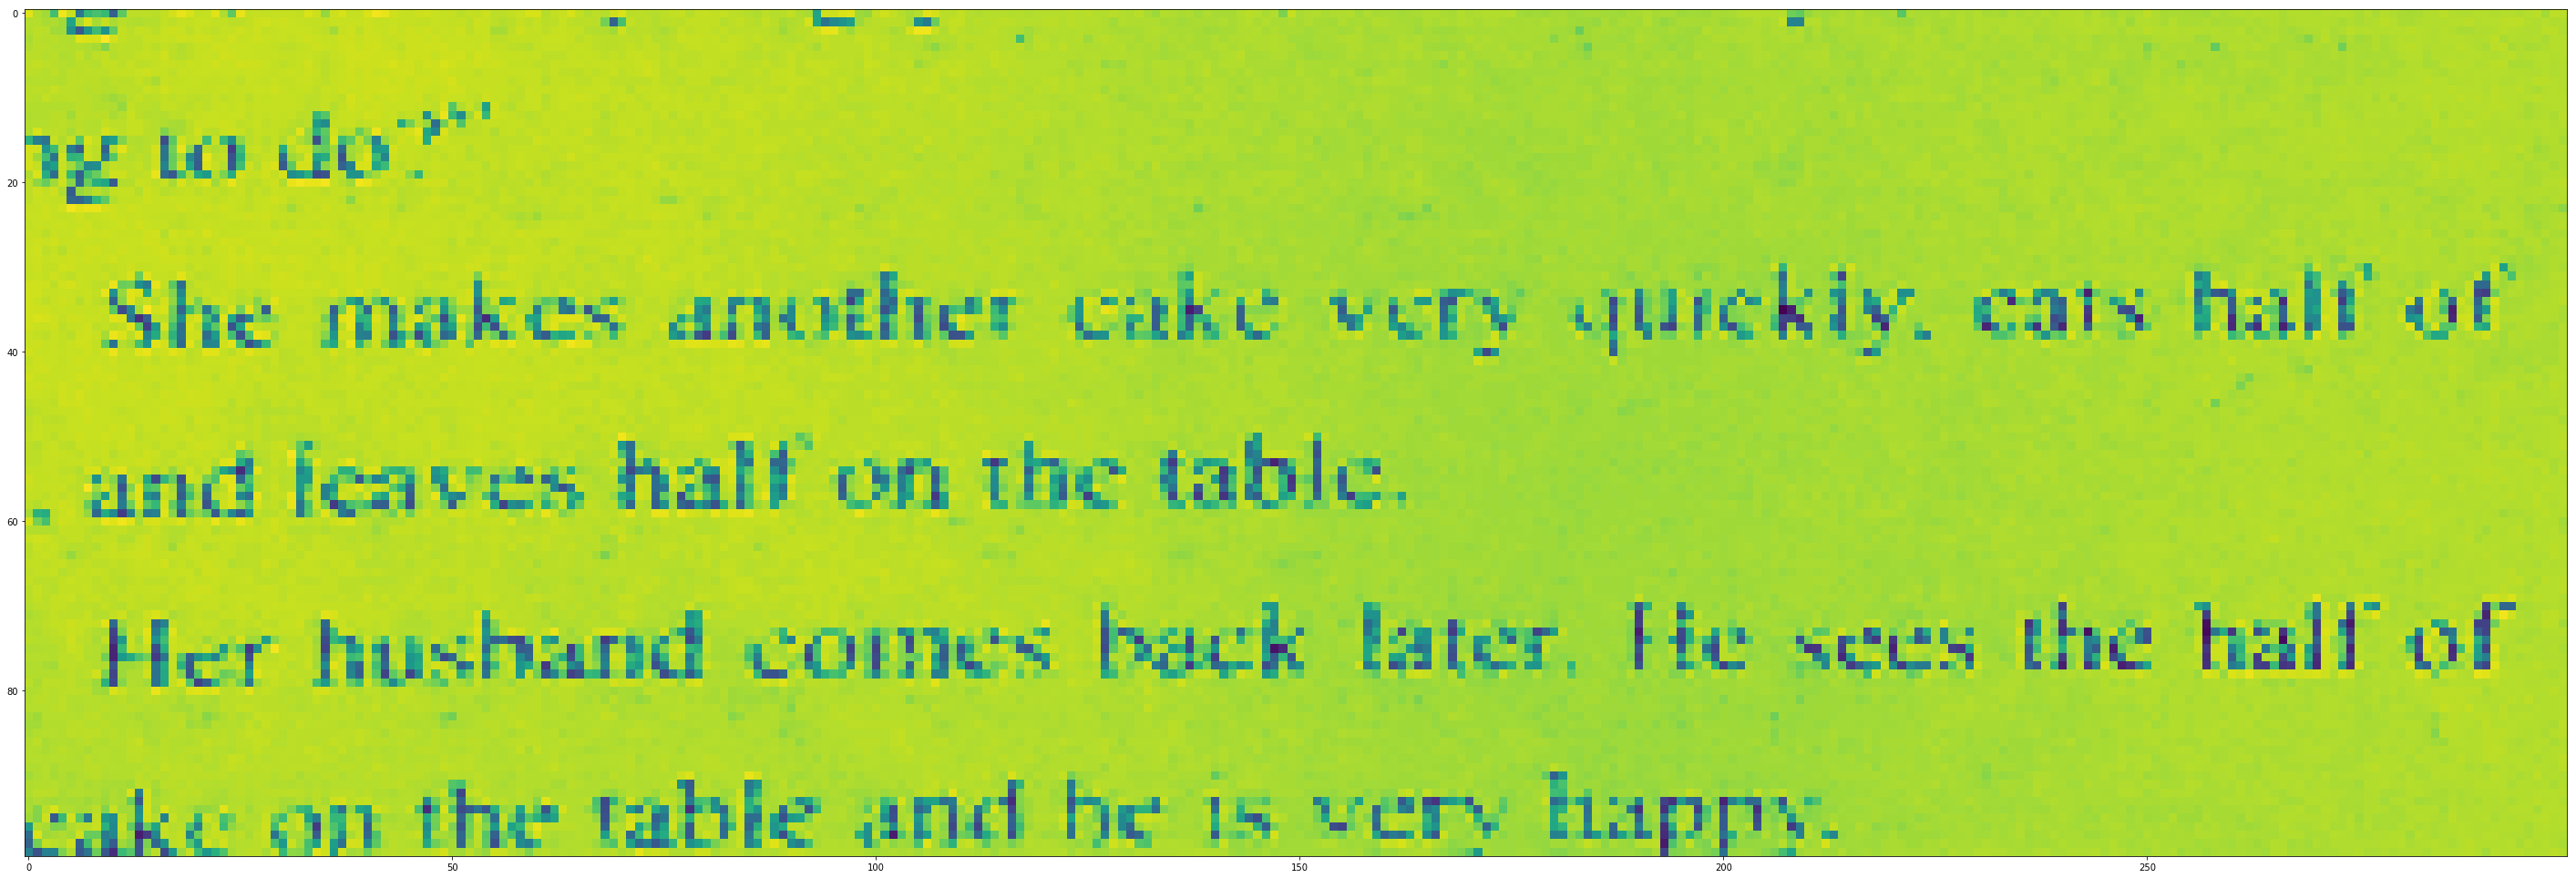

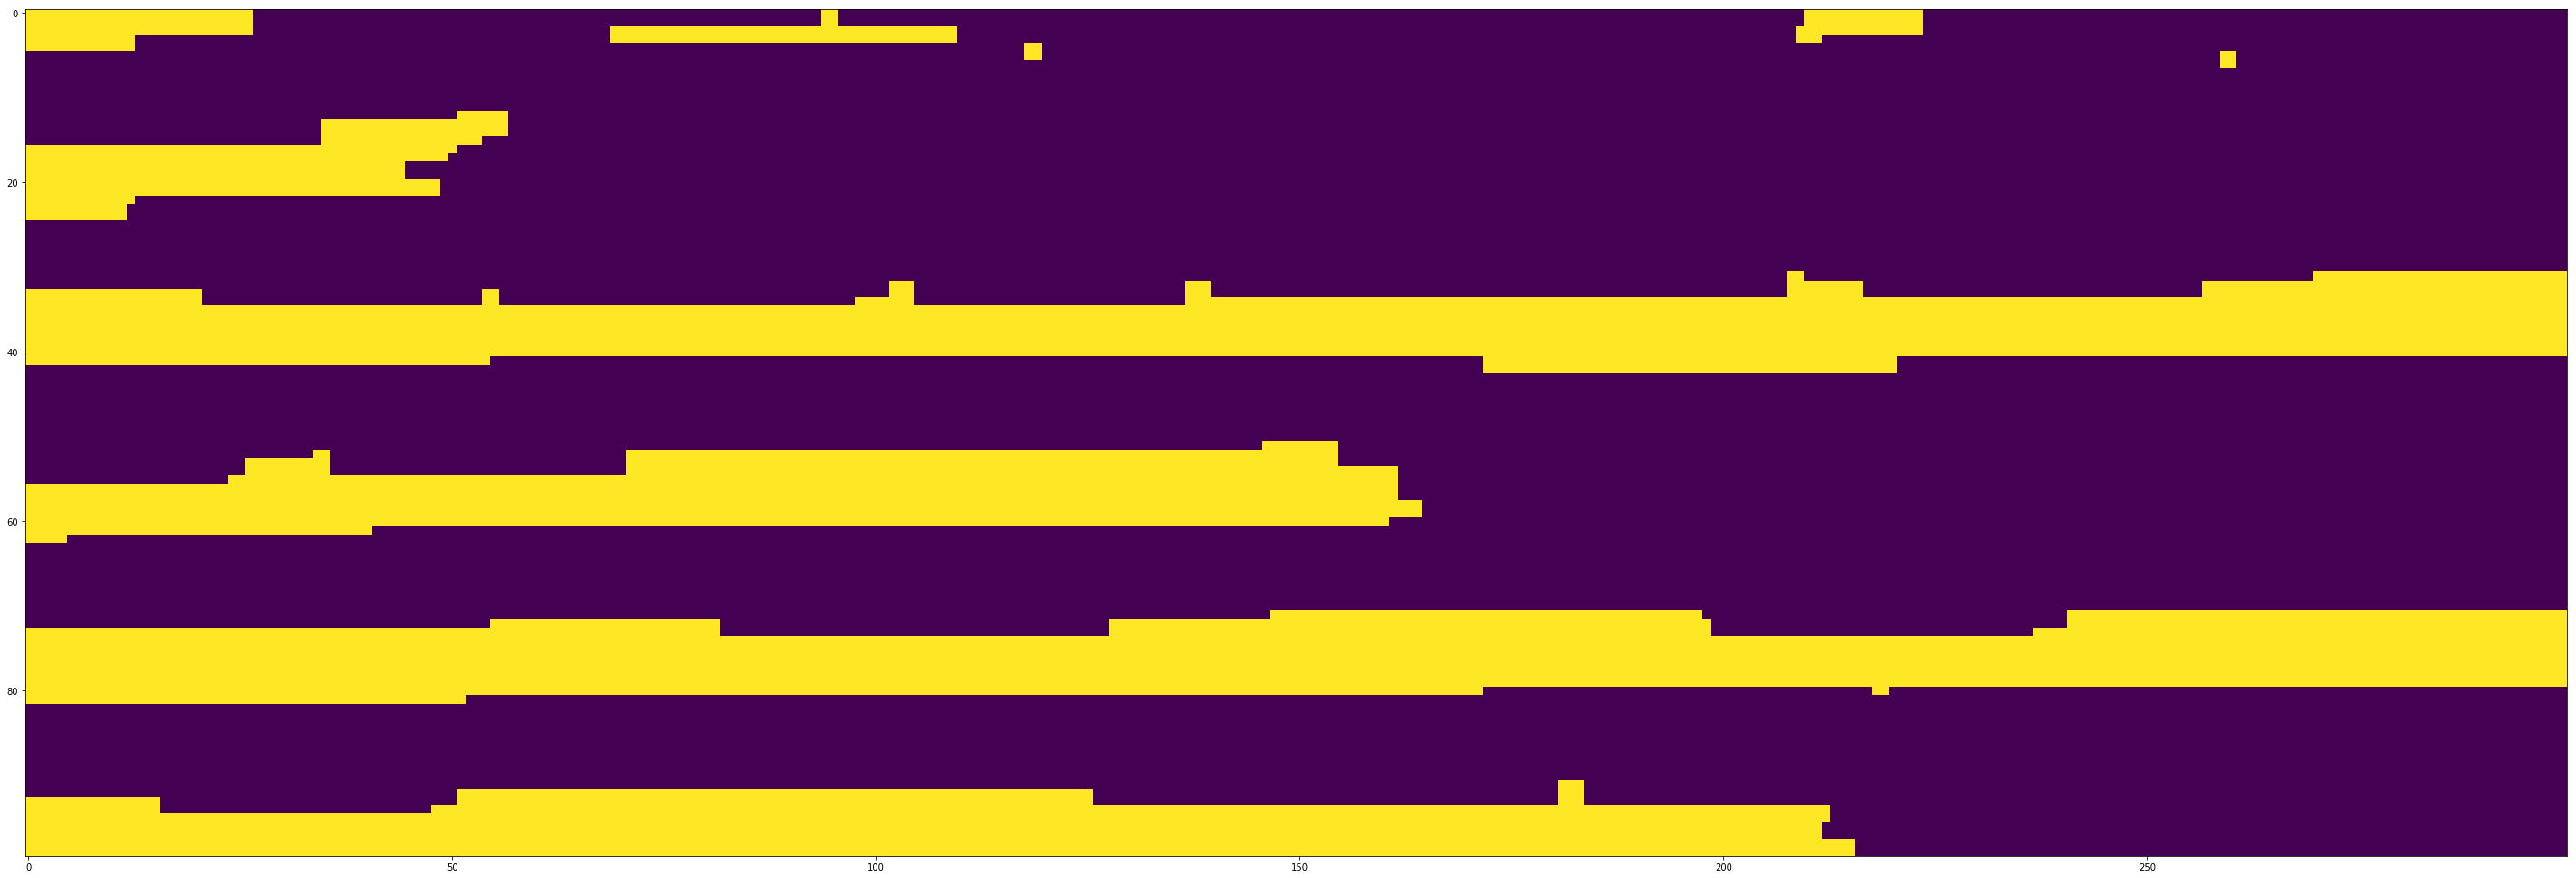

[ 9. 28. 47. 67. 86.]


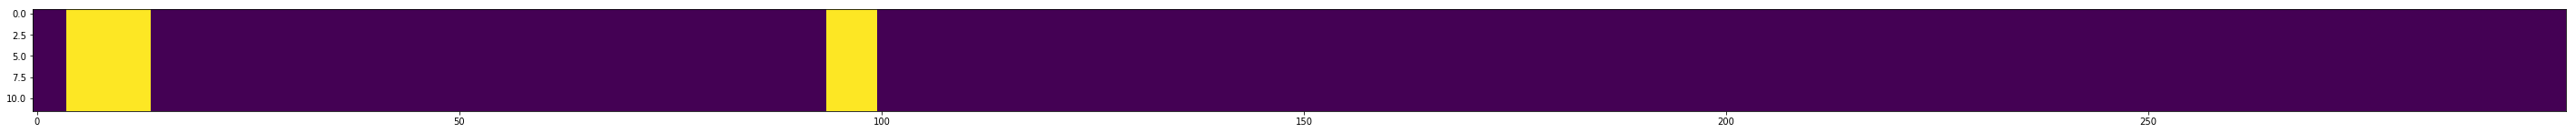

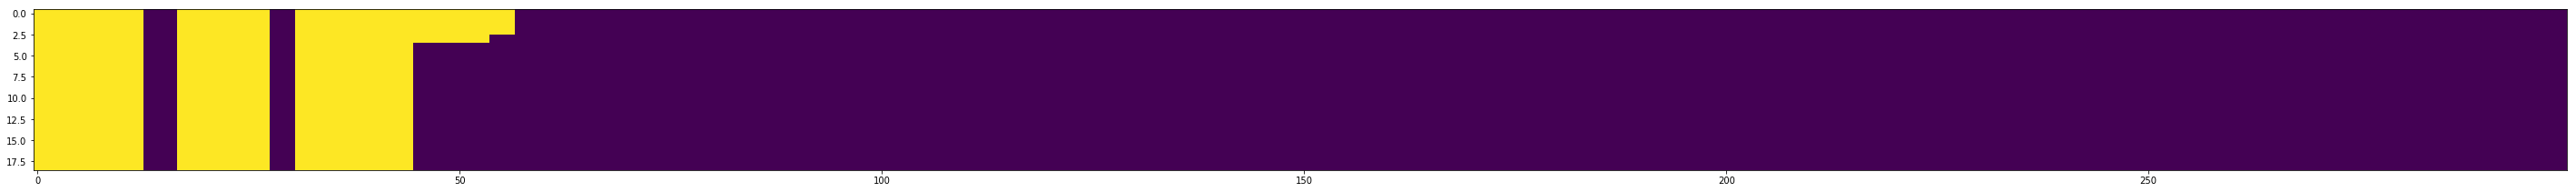

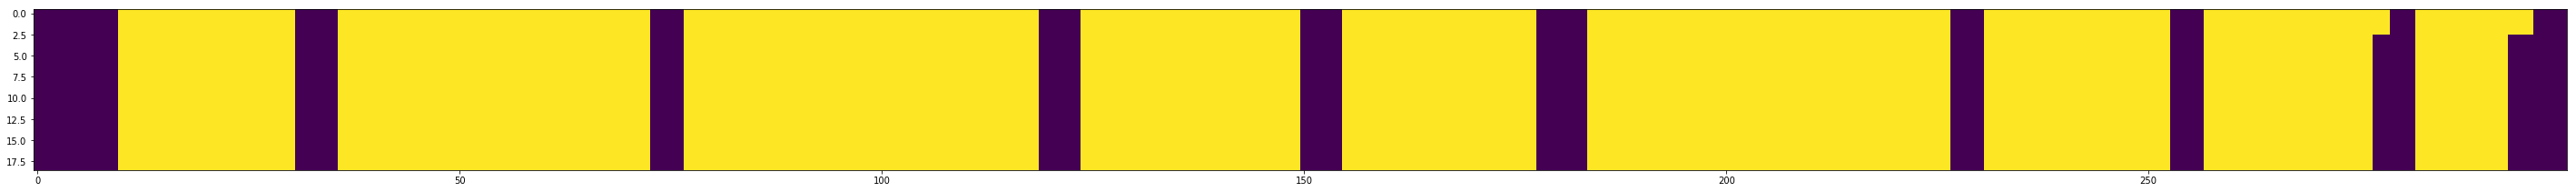

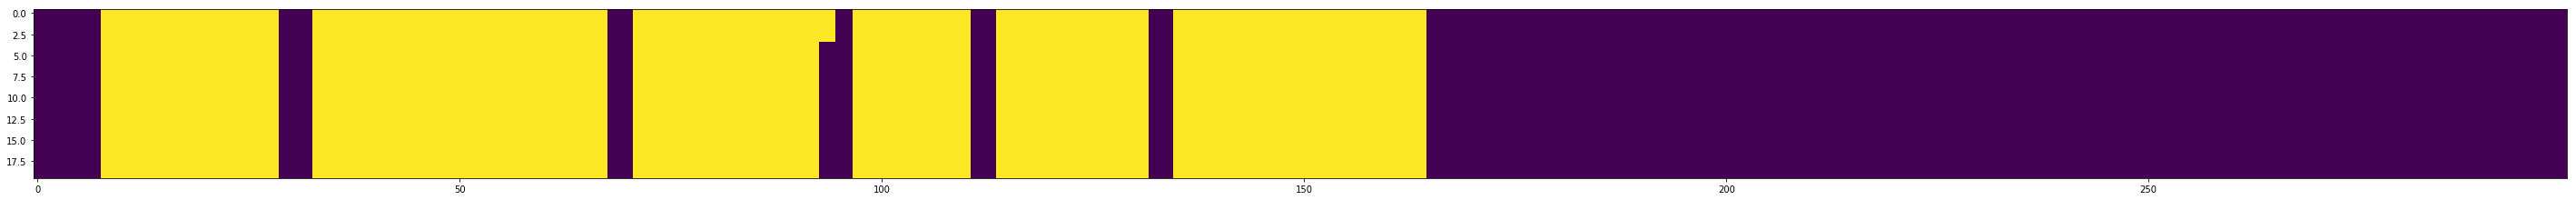

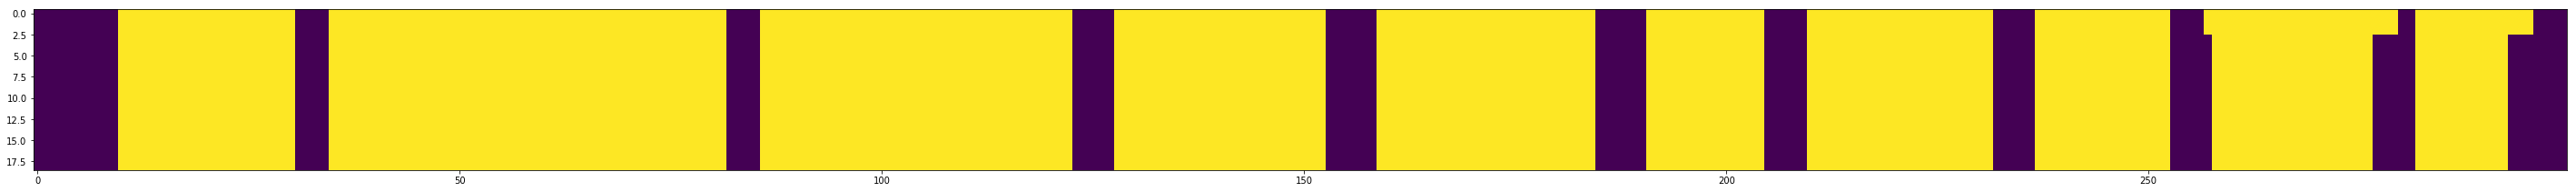

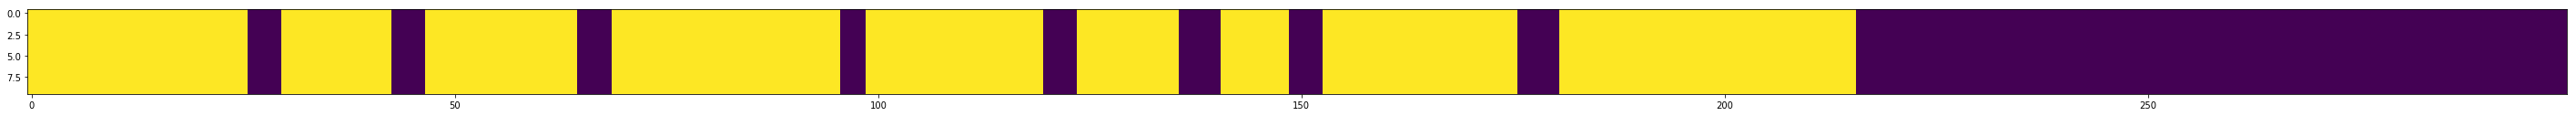

[array([[  0.,   0.,  54.,  12.],
       [ 54.,   0., 109.,  12.]]), array([[ 0., 12., 15., 31.],
       [15., 12., 29., 31.],
       [29., 12., 54., 31.]]), array([[  0.,  31.,  33.,  50.],
       [ 33.,  31.,  75.,  50.],
       [ 75.,  31., 121.,  50.],
       [121.,  31., 152.,  50.],
       [152.,  31., 181.,  50.],
       [181.,  31., 229.,  50.],
       [229.,  31., 255.,  50.],
       [255.,  31., 279.,  50.],
       [279.,  31., 299.,  50.]]), array([[  0.,  50.,  31.,  70.],
       [ 31.,  50.,  69.,  70.],
       [ 69.,  50.,  95.,  70.],
       [ 95.,  50., 112.,  70.],
       [112.,  50., 133.,  70.],
       [133.,  50., 174.,  70.]]), array([[  0.,  70.,  33.,  89.],
       [ 33.,  70.,  84.,  89.],
       [ 84.,  70., 125.,  89.],
       [125.,  70., 156.,  89.],
       [156.,  70., 188.,  89.],
       [188.,  70., 207.,  89.],
       [207.,  70., 234.,  89.],
       [234.,  70., 255.,  89.],
       [255.,  70., 279.,  89.],
       [279.,  70., 299.,  89.]]), array([[  0

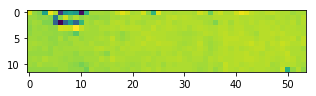

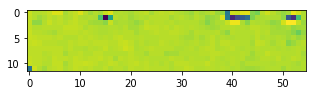

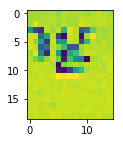

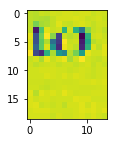

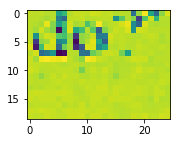

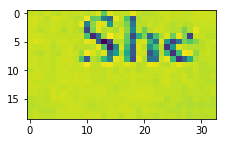

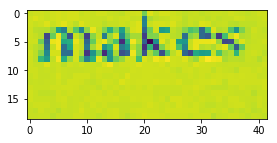

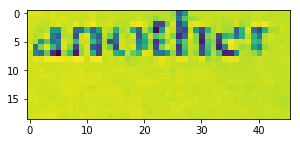

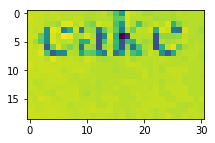

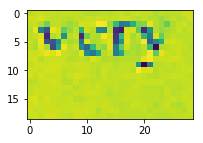

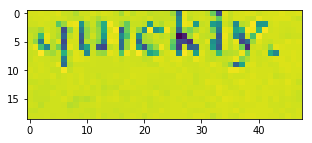

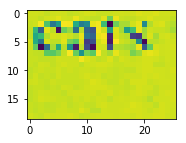

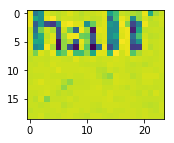

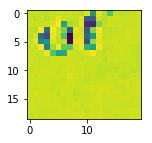

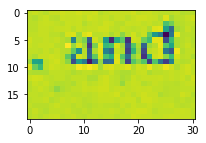

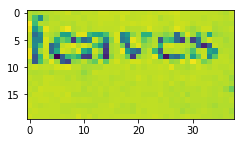

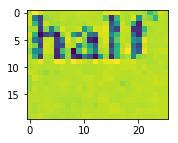

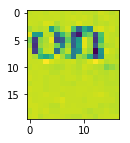

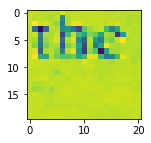

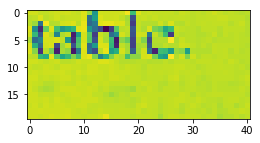

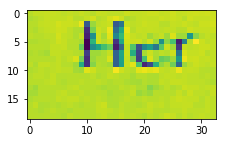

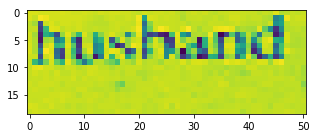

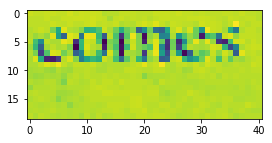

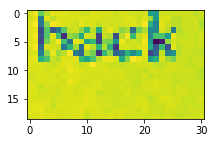

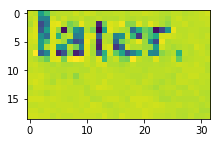

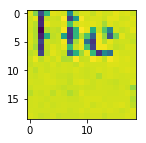

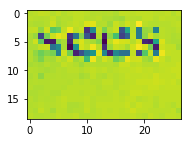

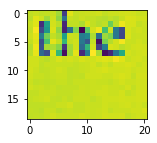

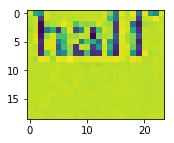

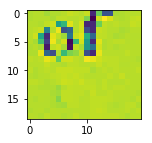

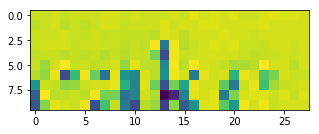

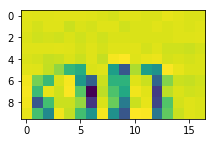

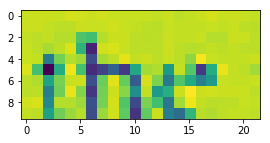

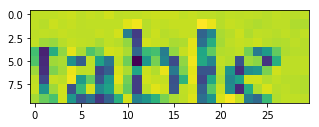

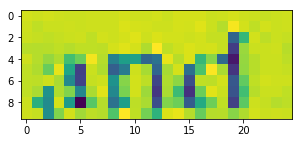

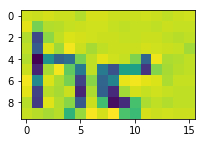

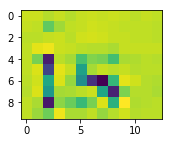

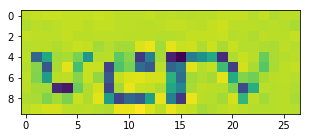

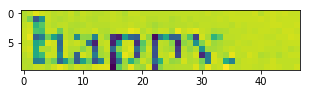

In [50]:
pp_img = cv2.imread("title/test.jpg",0)
pic = cv2.resize(pp_img, (700, 1000), interpolation=cv2.INTER_CUBIC)
plt.rcParams['figure.figsize'] = (50, 30)
# plt.imshow(pic)
# plt.show()
# plt.imshow(pic[500:600,100:400])
# plt.show()
cut_img = pic[500:600,100:400]
plt.imshow(cut_img)
plt.show()
cut_datas = run(cut_img)
plt.rcParams['figure.figsize'] = (5,2)
print(cut_datas)
for cut_data in cut_datas:
    i=0
    for cut in cut_data:
        i+=1
        xx = int(round(cut[2]))
        yy = int(round(cut[3]))

        x = int(round(cut[0]))
        y = int(round(cut[1]))
        tempp = cut_img[y:yy, x:xx]
        plt.imshow(tempp)
        plt.show()
#     break

In [51]:
# img = cv2.imread("train_info/train_images/2018_12_29_09/1546045755.451315.jpg",0)

# plt.imshow(img)
# plt.show()
# cut_datas = run(img)
# print(cut_datas)
# # sp1=img.shape
# # part_img_width=sp1[1]
# # part_img_height=sp1[0]
# for cut_data in cut_datas:
#     i=0
#     for cut in cut_data:
#         i+=1
#         xx = int(round(cut[2] ))
#         yy = int(round(cut[3] ))

#         x = int(round(cut[0] ))
#         y = int(round(cut[1] ))
#         tempp = img[y:yy, x:xx]
#         plt.imshow(tempp)
#         plt.show()

In [151]:
f = open("train_info1-5/train_info.txt")
i=0
n=0
new_f=file("train_info1-5/words_little.txt", "a+")
other_f = file("train_info1-5/words_self_other.txt", "a+")
for line in f.readlines():
    line_list = line.split(" ")
    
    path_old_list = line_list[0].split("-")
    path_old_list[-1]=path_old_list[-1][:-4]
    path_new = "-".join(path_old_list)
    line_new = path_new+" ok @ @ @ @ @ @ "+" ".join(line_list[2:])
    if len(line_list[2:])<=3:
        new_f.write(line_new)
    else:
        other_f.write(line_new)
        
new_f.close()
other_f.close()

NameError: name 'file' is not defined